# Aprendizaje no supervisado: Sistemas de recomendación
1.Objetivos
En este práctico tendrán que integrar en la notebook el sistema de recomendación basado en contenido que se propone en 
- [1] http://nbviewer.jupyter.org/github/khanhnamle1994/movielens/blob/master/Content_Based_
and_Collaborative_Filtering_Models.ipynb.

Los archivos los obtenemos de:

- https://github.com/khanhnamle1994/movielens.git

### Cargamos el Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('csv/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('csv/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('csv/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

#### Ratings Dataset

In [2]:
### Veamos que la informacion es similar a lo mostrado en [1]
print(ratings.head())
print(ratings.info())

   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB
None


#### Users Dataset

In [3]:
### Veamos que la informacion es similar a lo mostrado en [1]
print(users.head())
print(users.info())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id     6040 non-null int64
gender      6040 non-null object
zipcode     6040 non-null object
age_desc    6040 non-null object
occ_desc    6040 non-null object
dtypes: int64(1), object(4)
memory usage: 236.0+ KB
None


#### Movies Dataset

In [4]:
### Veamos que la informacion es similar a lo mostrado en [1]
print(movies.head())
print(movies.info())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


#### Titles
Particularmente me gusta le representacion que realiza de los titulos asique la repetimos

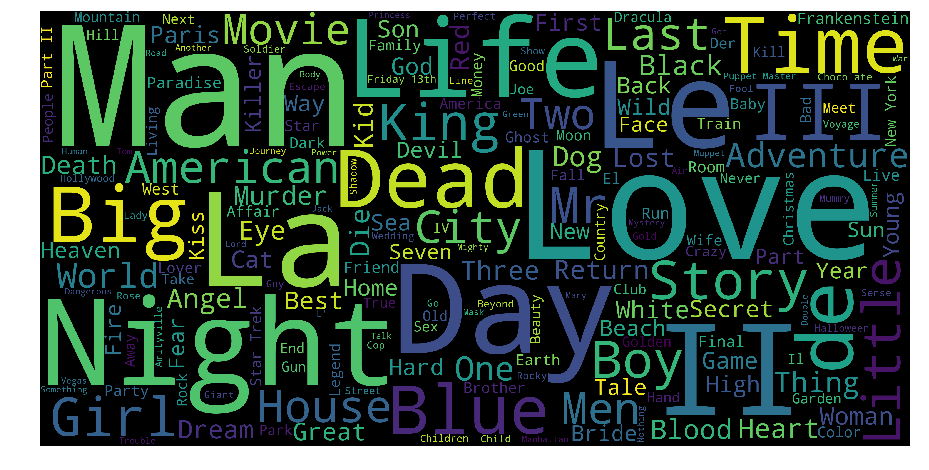

In [5]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

#### Genres

In [6]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:10]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211]]

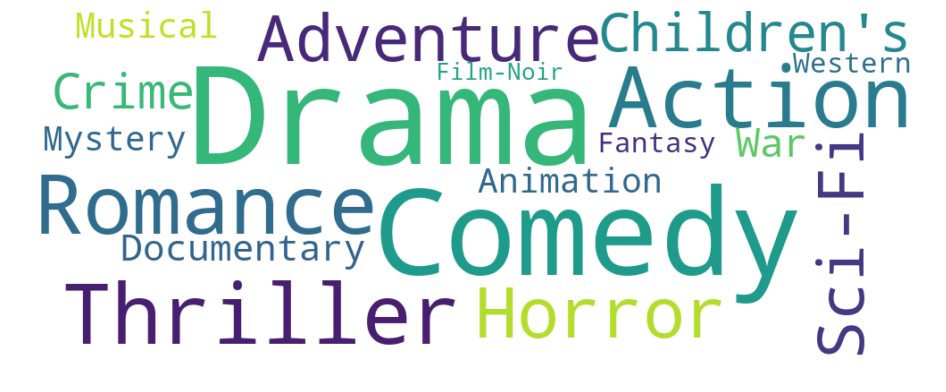

In [7]:
# y en forma similar a titulo
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Sistema de Recomendacion basado en contenido

Entonces avanzamos con el sistema de recomendacion indicado

<img src="rec-systems.png" width="600">

In [8]:
movies_back=pd.read_csv('csv/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])
movies=movies_back

In [9]:
# Para poder analizar basados en la tematica de la pelicula realizamos el split de genre

# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [10]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"
1,2,Jumanji (1995),"['Adventure', ""Children's"", 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama']"
4,5,Father of the Bride Part II (1995),['Comedy']


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

In [12]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [13]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
# Modificamos unicamente la cantidad maxima de recomendaciones
def genre_recommendations(title,max_rec=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:max_rec]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [14]:
# Probamos con el ejemplo dado
genre_recommendations('Toy Story (1995)')

1050            Aladdin and the King of Thieves (1996)
2072                          American Tail, An (1986)
2073        American Tail: Fievel Goes West, An (1991)
2285                         Rugrats Movie, The (1998)
2286                              Bug's Life, A (1998)
3045                                Toy Story 2 (1999)
3542                             Saludos Amigos (1943)
3682                                Chicken Run (2000)
3685    Adventures of Rocky and Bullwinkle, The (2000)
Name: title, dtype: object

In [15]:
# Y con alguna alternativa
genre_recommendations('Requiem for a Dream (2000)')

25                                       Othello (1995)
26                                  Now and Then (1995)
29    Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                               Dangerous Minds (1995)
35                              Dead Man Walking (1995)
39                      Cry, the Beloved Country (1995)
42                                   Restoration (1995)
52                                      Lamerica (1994)
54                                       Georgia (1995)
Name: title, dtype: object

### Género + año

Propongamos un filtrado mas en terminos de año ademas de genre

In [16]:
movies['year']=movies.title.apply(lambda x: [int(s) for s in x.split() if s.isdigit()])

In [17]:
import re
def getNums(xStr):
    """
#    Number extractor from string
#    Based on https://stackoverflow.com/questions/4289331/python-extract-numbers-from-a-string
#    """
    listNum=re.findall("^.*?\([^\d]*(\d+)[^\d]*\).*$", xStr)
    return listNum

def tryconvert(value, default, *types):
    for t in types:
        try:
            return t(value)
        except:
            continue
    return default

In [18]:
movies['year']=movies.title.apply(lambda x: tryconvert(getNums(x)[0],np.nan,int))

In [19]:
movies.head(5)

,movie_id,title,genres,year
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']",1995
1,2,Jumanji (1995),"['Adventure', ""Children's"", 'Fantasy']",1995
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']",1995
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama']",1995
4,5,Father of the Bride Part II (1995),['Comedy'],1995


In [20]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
# Modificamos: 
#-la cantidad maxima de recomendaciones 
#-sumamos el tema de buscar peliculas parecidas y contemporaneas (cercanas temporalmente [año de la pelicula-dt,año de la pelicula +dt])
def genre_recommendations_year(title,movies,max_rec=20,dt=5):
    idx = indices[title]
    dummy=movies.copy()
    dummy['diff_year']=dummy['year']-dummy['year'].iloc[idx]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:max_rec]
    movie_indices = [i[0] for i in sim_scores]
    df=dummy.iloc[movie_indices]
    rec_year=df[abs(df.diff_year)<=dt]
    return titles.iloc[movie_indices],movie_indices,rec_year

In [21]:
titles_gensim,_,titles_year_bound=genre_recommendations_year('Toy Story (1995)',movies,dt=2)
titles_year_bound

,movie_id,title,genres,year,diff_year
1050,1064,Aladdin and the King of Thieves (1996),"['Animation', ""Children's"", 'Comedy']",1996,1
236,239,"Goofy Movie, A (1995)","['Animation', ""Children's"", 'Comedy', 'Romance']",1995,0
12,13,Balto (1995),"['Animation', ""Children's""]",1995,0
241,244,Gumby: The Movie (1995),"['Animation', ""Children's""]",1995,0
310,313,"Swan Princess, The (1994)","['Animation', ""Children's""]",1994,-1
876,888,Land Before Time III: The Time of the Great Gi...,"['Animation', ""Children's""]",1995,0


In [22]:
# Y con alguna alternativa
titles_gensim,_,titles_year_bound=genre_recommendations_year('Requiem for a Dream (2000)',movies,dt=2)
titles_year_bound # notamos que cercanas temporalmente no tenemos ninguna dt=2

,movie_id,title,genres,year,diff_year


Notamos que cercanas temporalmente (en un rango de dos años) no tenemos ninguna :-)

In [23]:
titles_gensim,_,titles_year_bound=genre_recommendations_year('Requiem for a Dream (2000)',movies,dt=4)
titles_year_bound

,movie_id,title,genres,year,diff_year
92,94,Beautiful Girls (1996),['Drama'],1996,-4


Y si extendemos el rango (dt=4) recien aparece una unica pelicula.

In [24]:
titles_gensim,_,titles_year_bound=genre_recommendations_year('Requiem for a Dream (2000)',movies,dt=5)
titles_year_bound

,movie_id,title,genres,year,diff_year
25,26,Othello (1995),['Drama'],1995,-5
26,27,Now and Then (1995),['Drama'],1995,-5
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,['Drama'],1995,-5
30,31,Dangerous Minds (1995),['Drama'],1995,-5
35,36,Dead Man Walking (1995),['Drama'],1995,-5
39,40,"Cry, the Beloved Country (1995)",['Drama'],1995,-5
42,43,Restoration (1995),['Drama'],1995,-5
54,55,Georgia (1995),['Drama'],1995,-5
56,57,Home for the Holidays (1995),['Drama'],1995,-5
61,62,Mr. Holland's Opus (1995),['Drama'],1995,-5


Y si extendemos el rango (dt=5) vemos que ya aparece una buena cantidad.